In [ ]:
import torch
print(torch.__version__)
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from  sklearn import  datasets
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

1.9.0+cu102


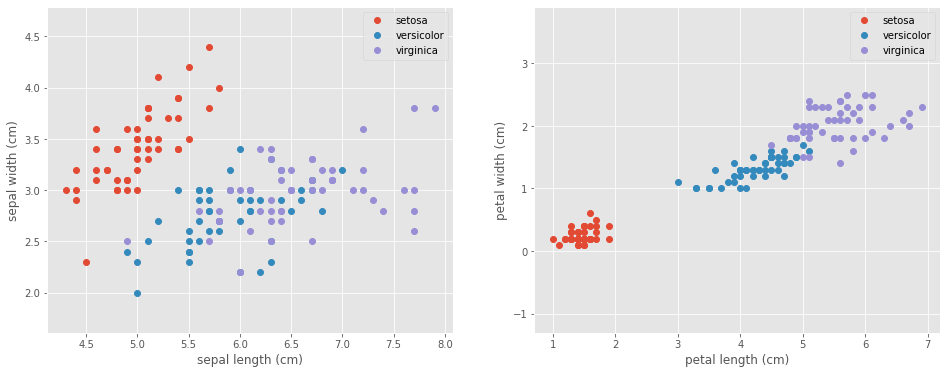

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)):
        _x = data[i:(i+seq_length)]
        x.append(_x)
        
    return np.array(x)

sc = MinMaxScaler()
X_scaled = sc.fit_transform(X)

seq_length = 1
x  = sliding_windows(X_scaled, seq_length)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=True)
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (105, 1, 4) (105,)
Testing Shape (45, 1, 4) (45,)


In [ ]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, targets):   #, transform=None
        self.data = data
        self.labels = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        
        x = torch.FloatTensor(x)
        y = torch.from_numpy(np.array(y))
        return x, y
    
    def __len__(self):
        return len(self.data)

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=5)
test_dataset = MyDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=5)

In [ ]:
from torch.autograd import Variable

class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length
        
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    h_0 = to_device(torch.zeros(self.num_layers, x.size(0), self.hidden_size), device) 
    c_0 = to_device(torch.zeros(self.num_layers, x.size(0), self.hidden_size), device)
        
    # Propagate input through LSTM
    ula, (h_out, _) = self.lstm(x, (h_0, c_0))   
    h_out = h_out.view(-1, self.hidden_size)   
    out = self.fc(h_out)
        
    return out

  def training_step(self, batch):
    data, labels = batch 
    out = self(data)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return acc, loss
    
  def validation_step(self, batch):
    data, labels = batch 
    out = self(data)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}
        
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}]: train_acc: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_acc'], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
train_dl = DeviceDataLoader(train_dataloader, device)
val_dl = DeviceDataLoader(test_dataloader, device)

In [ ]:
num_epochs = 500
learning_rate = 0.001

input_size = X_train.shape[2]  #1,1,4
hidden_size = 2
num_layers = 1

num_classes = 3

model = to_device(LSTM(num_classes, input_size, hidden_size, num_layers), device)
model

LSTM(
  (lstm): LSTM(4, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

best_acc = -np.inf
history = []
# Train the model
for epoch in range(num_epochs):
  # Training Phase 
  # model.train()
  train_acc = []
  train_losses = []
  for batch in train_dl:
    acc, loss = model.training_step(batch)
    train_acc.append(acc)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  # Validation phase
  result = evaluate(model, val_dl)
  result['train_acc'] = torch.stack(train_acc).mean().item()
  result['train_loss'] = torch.stack(train_losses).mean().item()
    
  if result['val_acc']>best_acc:
    best_acc = result['val_acc']
    best_acc = result['val_acc']
    torch.save(model.state_dict(), 'lstm-iris.pth')

  model.epoch_end(epoch, result)
  history.append(result)

Epoch [0]: train_acc: 0.3048, train_loss: 1.2420, val_loss: 1.1361, val_acc: 0.4000
Epoch [1]: train_acc: 0.3048, train_loss: 1.2232, val_loss: 1.1236, val_acc: 0.4000
Epoch [2]: train_acc: 0.3048, train_loss: 1.2058, val_loss: 1.1116, val_acc: 0.4000
Epoch [3]: train_acc: 0.3048, train_loss: 1.1890, val_loss: 1.0998, val_acc: 0.4000
Epoch [4]: train_acc: 0.3048, train_loss: 1.1725, val_loss: 1.0882, val_acc: 0.4000
Epoch [5]: train_acc: 0.3048, train_loss: 1.1562, val_loss: 1.0767, val_acc: 0.4000
Epoch [6]: train_acc: 0.3048, train_loss: 1.1402, val_loss: 1.0654, val_acc: 0.4000
Epoch [7]: train_acc: 0.3048, train_loss: 1.1247, val_loss: 1.0545, val_acc: 0.4000
Epoch [8]: train_acc: 0.3048, train_loss: 1.1096, val_loss: 1.0439, val_acc: 0.4000
Epoch [9]: train_acc: 0.3048, train_loss: 1.0949, val_loss: 1.0335, val_acc: 0.4000
Epoch [10]: train_acc: 0.3048, train_loss: 1.0807, val_loss: 1.0233, val_acc: 0.4000
Epoch [11]: train_acc: 0.3048, train_loss: 1.0668, val_loss: 1.0132, val_ac

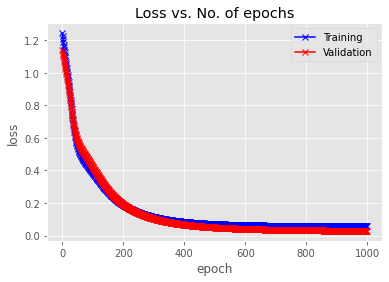

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

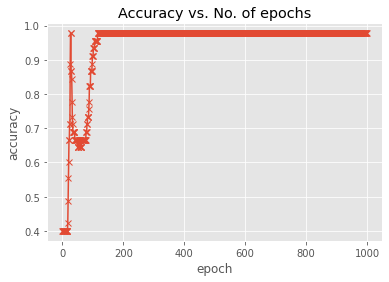

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=10), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9800000190734863, 'val_loss': 0.03172047808766365}

>loaded /content/lstm-iris.pth


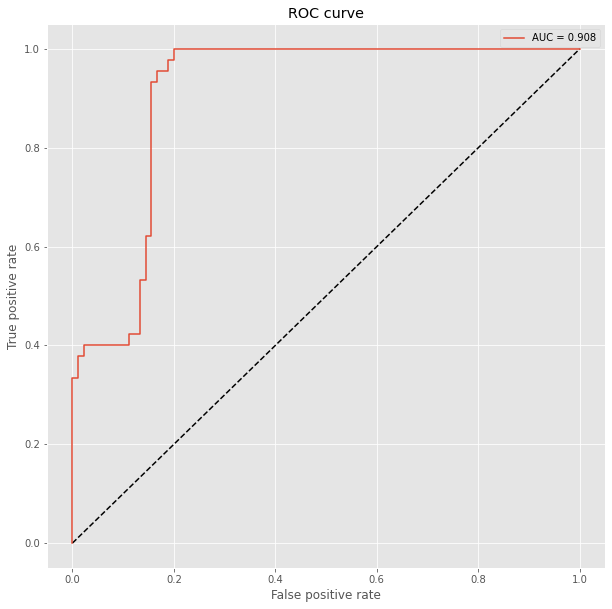

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

filename = "/content/lstm-iris.pth" 
model.load_state_dict(torch.load(filename, map_location=device))
print('>loaded %s' % filename)
model.to(device)
model.eval()
#to_device(model, device)

with torch.no_grad():
    y_pred = model(to_device(torch.FloatTensor(X_test), device))
    y_pred = y_pred.cpu().detach().numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [ ]:
from torch.autograd import Variable

file_name = "/content/lstm-iris.pth" 
#model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.load_state_dict(torch.load(file_name))
print('>loaded %s' % file_name)
model.eval()

# Prediction
my_test = Variable(torch.from_numpy(X_test)).float()
model.to(device)
pred = model(to_device(my_test, device))
pred = pred.cpu().detach().numpy()
pred

>loaded /content/lstm-iris.pth


array([[ 1.51409954e-01, -2.45874748e-02, -1.05660963e+00],
       [-4.49323237e-01,  4.88717668e-02, -2.68880904e-01],
       [-6.53080821e-01,  4.67080884e-02, -7.59069026e-02],
       [ 1.00178570e-01, -1.48497969e-02, -9.79913712e-01],
       [-9.53827381e-01,  5.85877970e-02,  2.50229865e-01],
       [-7.27984071e-01,  5.48762120e-02,  1.95957720e-02],
       [-9.37394500e-01,  7.76090473e-02,  2.86314160e-01],
       [ 2.64452696e-02, -8.17833841e-03, -8.89654636e-01],
       [ 2.16204226e-02, -1.71901286e-03, -8.67243588e-01],
       [-9.96216655e-01,  7.78878331e-02,  3.44498962e-01],
       [-6.50062799e-01,  5.70416525e-02, -5.05350232e-02],
       [ 6.30238056e-02, -1.35760158e-02, -9.40153480e-01],
       [-9.94031310e-01,  7.41951764e-02,  3.32246393e-01],
       [-6.79556966e-01,  5.01806736e-02, -4.05452549e-02],
       [-7.18435168e-01,  5.93477525e-02,  2.25280821e-02],
       [ 3.97609472e-02,  3.20076942e-04, -8.79364014e-01],
       [-5.99855006e-01,  5.11952341e-02

In [ ]:
from sklearn.metrics import accuracy_score
print ("The accuracy is", accuracy_score(y_test, np.argmax(pred, axis=1)))

The accuracy is 0.9777777777777777


In [ ]:
np.argmax(pred, axis=1)

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       2, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2, 2,
       1])

In [ ]:
y_test

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2, 2,
       1])

In [ ]:
# Checking for a single instance / predicted class label
test0 = torch.reshape(Variable(torch.Tensor(X_test[4])), (1, 1, 4)).float()
model.to(device)
pred = model(to_device(test0, device))
pred = pred.cpu().detach().numpy()
pred

array([[-0.9538274 ,  0.0585878 ,  0.25022987]], dtype=float32)

In [ ]:
pred = np.argmax(pred, axis=1)
pred[0]

2

In [ ]:
# Actual class label
y_test[4]

2